# CRAFTY

## Dataset

Importo i dataset con `pandas` cercando di risparmiare memoria andando a specificare, tramite
il parametro `dtype` il tipo e la dimensione dei dati di ogni colonna.

In questo modo risparmiao quasi 1GB di RAM e velocizzo il caricamento del dataset. Sono stato in
parte costretto a procedere in questo modo poiché non sempre riuscivo a contenere tutti i dati
generati nella RAM della macchina.

Più avanti andrò inoltre a deallocare i DataFrame più grandi una volta che questi non sono più necessari.
Questo potrebbe creare qualche problema nel caso si voglia eseguire tutto il notebook e in seguito eseguire
qualche cella specifica poiché si potrebbe far riferimento a dati già deallocati.

Ovviamente eliminando o commentando le righe di codice in cui viene fatta la deallocazione non si avrebbe
questo problema ma nel mio caso è stato necessario per riuscire ad eseguire il notebook senza saturare la RAM.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import bs4
import requests
import time

n = None

tx_df = pd.read_csv(
    "transactions.csv",
    names=["timestamp", "blk", "tx", "is_coinbase", "fee"],
    dtype={
        "timestamp": np.uint32,
        "blk": np.uint32,
        "tx": np.uint32,
        "is_coinbase": np.uint8,
        "fee": np.uint64,
    },
    nrows=n,
)
tx_df["timestamp"] = pd.to_datetime(tx_df["timestamp"], unit="s")
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532115 entries, 0 to 10532114
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   timestamp    datetime64[ns]
 1   blk          uint32        
 2   tx           uint32        
 3   is_coinbase  uint8         
 4   fee          uint64        
dtypes: datetime64[ns](1), uint32(2), uint64(1), uint8(1)
memory usage: 251.1 MB


## Analisi

In questa prima fase andiamo ad effettuare delle analisi generali sul dataset.

### Distribuzione del numero di transazioni per blocco

Vogliamo ricavare la **distribuzione** del numero di transazioni per blocco, nell'intero periodo
temporale considerato.

Per prima cosa raggruppiamo il dataset per blocco.


In [2]:
blk_grp = tx_df.groupby("blk")

Dato che ogni riga del dataset rappresenta una transazione e dato che ogni transazione ha un
identificatore univoco, questa comparirà al più una volta nel dataset.

Siamo quindi in grado di ottenere il numero di transazioni per blocco tramite la funzione di
aggregazione `count`.


In [3]:
tx_per_blk = blk_grp["tx"].count()

#### Plot

Come sistema di plotting per la distribuzione del numero di transazioni per blocco ho fornito due
punti di vista:

- Istogramma delle frequenze di ogni dimensione dei blocchi trovata.
- Distribuzione della dimensione dei blocchi nel tempo con un grafico a barre approssimato.

Per plottare la seconda distribuzione ho optato per un grafico a barre ma plottare una barra per
ogni blocco (quasi 200000 blocchi) sarebbe stato troppo lungo.

Ho quindi deciso di raggruppare il dataset ulteriormente. Dato che volevo 30 barre avevo bisogno di
raggruppare ogni $n$ righe. Dove $n$ viene calcolato dividendo la lunghezza del dataset per 30.

Ho infine calcolato la media di ogni gruppo ottenuto per avere una rappresentazione del numero di transazioni
per blocco.


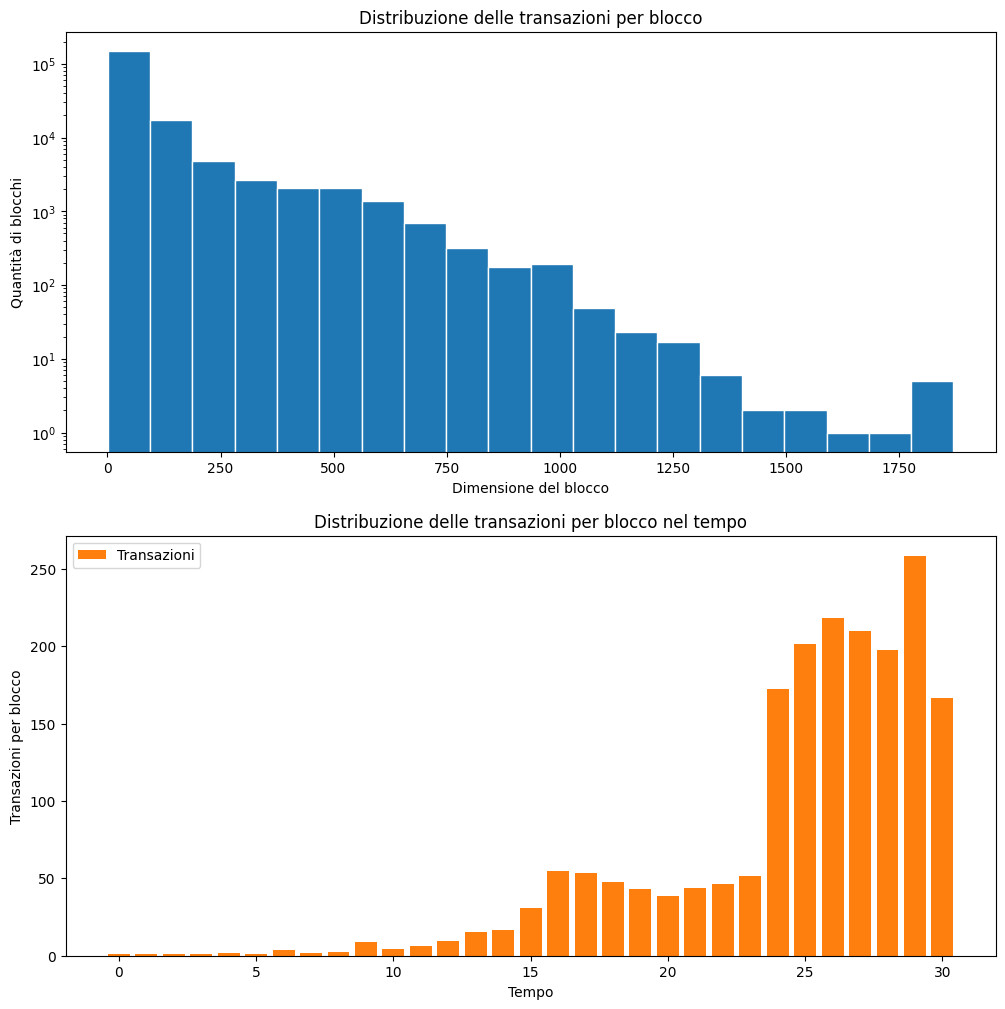

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.hist(tx_per_blk, bins=20, ec="w")
ax1.set_title("Distribuzione delle transazioni per blocco")
ax1.set_xlabel("Dimensione del blocco")
ax1.set_ylabel("Quantità di blocchi")
ax1.set_yscale("log")

bins = 30
group_size = len(tx_per_blk) // bins
tx_per_blk_approx = tx_per_blk.groupby(np.arange(len(tx_per_blk)) // group_size).mean()

ax2.bar(
    tx_per_blk_approx.index,
    tx_per_blk_approx,
    color="tab:orange",
    label="Transazioni",
)
ax2.set_title("Distribuzione delle transazioni per blocco nel tempo")
ax2.set_xlabel("Tempo")
ax2.set_ylabel("Transazioni per blocco")
ax2.legend()

plt.show()

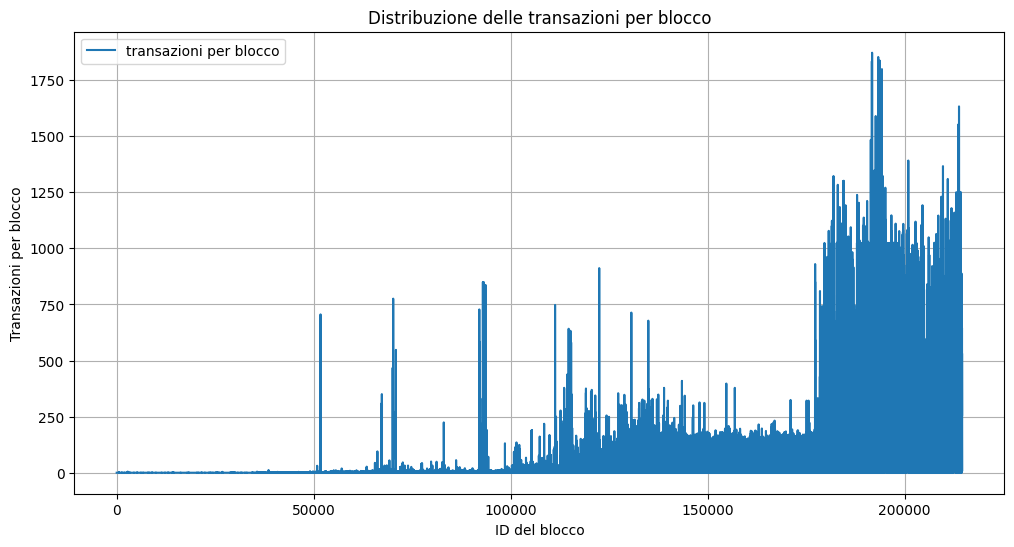

In [5]:
x = tx_per_blk.index.to_list()
y = tx_per_blk.values.tolist()

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="transazioni per blocco")

plt.title("Distribuzione delle transazioni per blocco")
plt.xlabel("ID del blocco")
plt.ylabel("Transazioni per blocco")
plt.legend()
plt.grid()
plt.show()

### Occupazione dei blocchi nel tempo

La seconda analisi prevede lo studio di come l'occupazione dei blocchi si è evoluta nel tempo.

In particolare dobbiamo andare a considerare intervalli di due mesi.

Dato che avevamo già raggruppato il dataset per blocchi, ho deciso di considerare come data di
riferimento, la data della transazione meno recente come data di riferimento di ogni blocco.


In [6]:
# transazioni per blocco con timestamp
tx_per_blk = pd.concat([tx_per_blk, blk_grp["timestamp"].min()], axis="columns")
tx_per_blk = tx_per_blk.rename(columns={"tx": "tx_count"})

Ho infine utilizzato l'oggetto `Grouper` di Pandas per riuscire ad interagire comodamente con le
date ed effettuare un raggruppamento bimestrale dei blocchi.

Per ogni gruppo ho infine calcolato l'occupazione media dei blocchi.


In [7]:
tx_per_blk = (
    tx_per_blk.groupby(pd.Grouper(key="timestamp", freq="2MS"))["tx_count"]
    .mean()
    .to_frame()
    .reset_index()
)

#### Plot

Come metodologia di plotting ho optato per un semplice plot in grado di fornire una rappresentazione
accurata dell'occupazione media dei blocchi ogni due mesi.


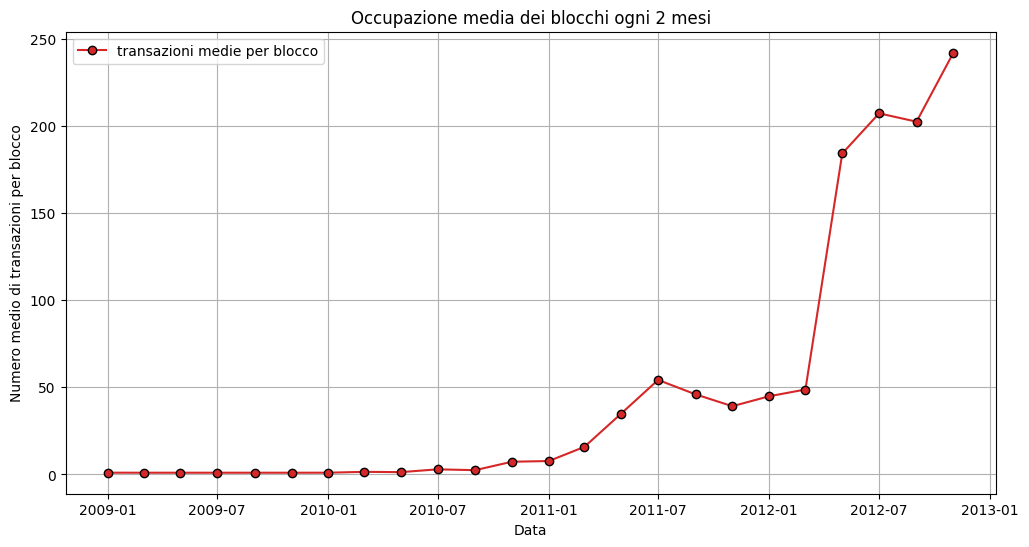

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(
    tx_per_blk["timestamp"],
    tx_per_blk["tx_count"],
    c="tab:red",
    marker="o",
    mec="k",
    label="transazioni medie per blocco",
)

plt.title("Occupazione media dei blocchi ogni 2 mesi")
plt.xlabel("Data")
plt.ylabel("Numero medio di transazioni per blocco")
plt.grid()
plt.legend()
plt.show()

### Totale UTXO

Passiamo ora a calcolare l'ammontare totale degli **UTXO** al momento dell'ultima transazione
registrata nel dataset.

L'idea è quella di calcolare prima tutto l'output che è stato speso e poi sottrarlo dall'output
totale prodotto.

Per arrivare a questo risultato effettuiamo un'operazione di `merge` tra il dataset degli **input**
e il dataset degli **output**.

Dato che non abbiamo identificatori univoci per ogni output ma solo per le transazioni, per
calcolare l'UTXO totale dobbiamo:

- Considerare le transazioni mai riferite come input da altre transazioni.
- Considerare gli output mai riferiti da altre transazioni che però riferiscono altri output
  all'interno della stessa transazione.

Ho deciso quindi di filtrare il dataset degli output eliminando

Ho deciso quindi di implementare l'operazione di `merge` (in questo caso di tipo _inner_) basandomi
sia sulle transazioni che sugli output riferiti in input.

Il risultato sarà un DataFrame `spent_df` in cui ogni riga è identificata univocamente dalla coppia
`(in_tx, out_pos)`.

In questo modo otterremo un dataset in cui saranno presenti solo le transazioni riferite come input
da altre transazioni.


In [9]:
in_df = pd.read_csv(
    "inputs.csv",
    names=["tx", "utxo_tx", "utxo_out_pos"],
    dtype={"tx": np.uint32, "utxo_tx": np.uint32, "out_pos": np.uint16},
    nrows=n,
)

out_df = pd.read_csv(
    "outputs.csv",
    names=["tx", "out_pos", "address", "amount", "script_type"],
    dtype={
        "tx": np.uint32,
        "out_pos": np.uint16,
        "address": np.uint32,
        "amount": np.uint64,
        "script_type": np.uint8,
    },
    nrows=n,
)

spent_df = (
    out_df.merge(
        in_df,
        how="inner",
        left_on=["tx", "out_pos"],
        right_on=["utxo_tx", "utxo_out_pos"],
    )
    .rename(columns={"tx_x": "in_tx", "tx_y": "tx"})
    .drop(columns=["utxo_tx", "utxo_out_pos", "script_type"])
)

del in_df

spent_df

,in_tx,out_pos,address,amount,tx
0,9,0,9,5000000000,171
1,78,0,78,5000000000,724715
2,171,0,171,1000000000,156739
3,171,1,9,4000000000,183
4,183,1,9,3000000000,185
...,...,...,...,...,...
21378765,10572820,3,3534212,10000000,10572821
21378766,10572820,4,3535501,10000000,10572822
21378767,10572820,5,3525822,10000000,10572824
21378768,10572820,6,3517234,10000000,10572825


A questo punto possiamo sommare i valori della colonna `amount` del DataFrame `spent_df` per
ricavare l'output speso.

Se invece sommiamo i valori della colonna `amount` del dataset degli **output** generati in tutto
il periodo di tempo considerato ricaviamo il valore totale degli output sia speso che non speso.

Calcolando la differenza tra il il valore totale degli output e il valore totale degli output spesi
ricaviamo l'**UTXO** totale.


In [10]:
utxo = out_df["amount"].sum() - spent_df["amount"].sum()
print(f"UTXO totale: {utxo}")

del out_df

UTXO totale: 859303372614879


#### Plot

Tramite un grafico a torta è possibile comparare l'output speso con l'**UTXO**.


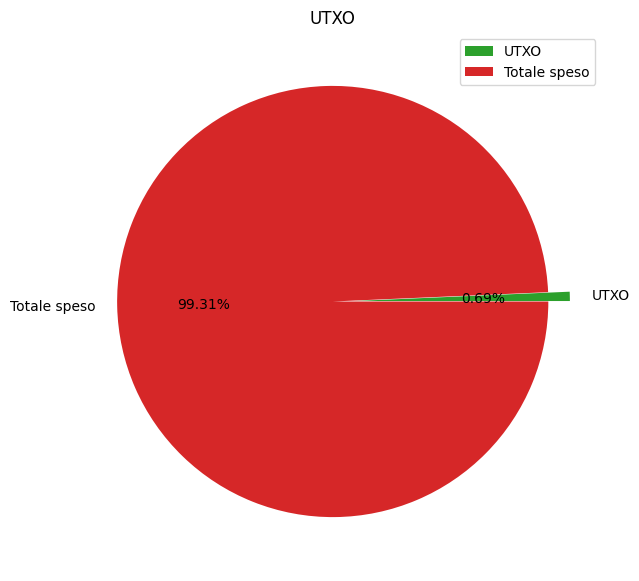

In [11]:
plt.figure(figsize=(10, 7))
plt.pie(
    [utxo, spent_df["amount"].sum()],
    explode=(0.1, 0),
    labels=["UTXO", "Totale speso"],
    colors=["tab:green", "tab:red"],
    autopct="%.2f%%",
)

plt.title("UTXO")
plt.legend()
plt.show()

### Distribuzione intervalli di tempo per il consumo di un output

Abbiamo già a disposizione un DataFrame che mette in correlazione gli input e gli output.

Per capire dopo quanto tempo è stato speso un output dobbiamo aggiungere il valore di `timestamp`
sia per il valore in input che per il valore in output.

Per riuscire a farlo ho effettuato un doppio `merge` con il DataFrame delle transazioni.


In [12]:
spent_time_df = (
    spent_df.merge(tx_df, how="inner", on="tx")
    .drop(columns=["blk", "tx", "is_coinbase", "fee"])
    .rename(columns={"timestamp": "spent_time"})
)

spent_time_df = (
    spent_time_df.merge(tx_df, how="inner", left_on="in_tx", right_on="tx")
    .drop(columns=["blk", "tx", "is_coinbase", "fee"])
    .rename(columns={"timestamp": "gen_time"})
)

days = (spent_time_df["spent_time"] - spent_time_df["gen_time"]).dt.days

#### Plot

A questo punto abbiamo una Series `days`, contenente il numero di giorni di vita di ogni transazione.

Sull'asse $x$ abbiamo la lunghezza degli intervalli di tempo (in giorni) prima che un output
venisse speso.

Sull'asse $y$ abbiamo invece la quantità di output che vengono spesi ogni $x$ giorni.


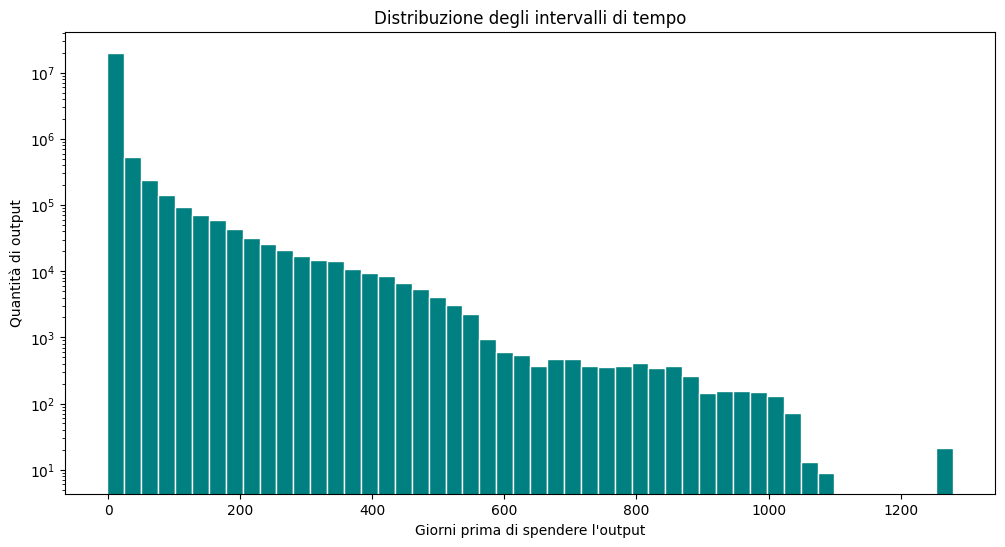

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(days, bins=50, ec="w", color="teal")

plt.title("Distribuzione degli intervalli di tempo")
plt.xlabel("Giorni prima di spendere l'output")
plt.ylabel("Quantità di output")
plt.yscale("log")

### Distribuzione delle fee

In quest'ultima fase vogliamo effettuare due analisi:

1. Vedere se esiste una correlazione tra il numero di _fee_ al mese e il valor medio di _fee_ al
   mese.
2. Mettere a confronto la distribuzione di _fee_ nulle e la distribuzione di _fee_ non nulle nel
   tempo.

#### Correlazione tra numero di _fee_ e il loro valore

Raggruppiamo il dataset per mese e ricaviamo il numero di _fee_ e il valor medio di mensile.


In [14]:
ts_grp = tx_df.groupby(pd.Grouper(key="timestamp", freq="1MS"))
fee_count = ts_grp["fee"].count()
fee_value = ts_grp["fee"].mean()

Vogliamo ora dividere il dataset in due parti:

- Transazioni con _fee_ nulle.
- Transazioni con _fee_ non nulle.

Una volta separati andiamo a raggruppare nuovamente per mese e calcoliamo, per entrambi i dataset
ricavati, il numero di _fee_ mensile.


In [15]:
zero_fee = tx_df[tx_df["fee"] == 0]
non_zero_fee = tx_df[tx_df["fee"] > 0]

zero_fee_count = zero_fee.groupby(pd.Grouper(key="timestamp", freq="2MS"))[
    "fee"
].count()

non_zero_fee_count = non_zero_fee.groupby(pd.Grouper(key="timestamp", freq="2MS"))[
    "fee"
].count()

del tx_df

#### Plot

Dato che abbiamo calcolato due distribuzioni ho optato per effettuare un doppio plot.


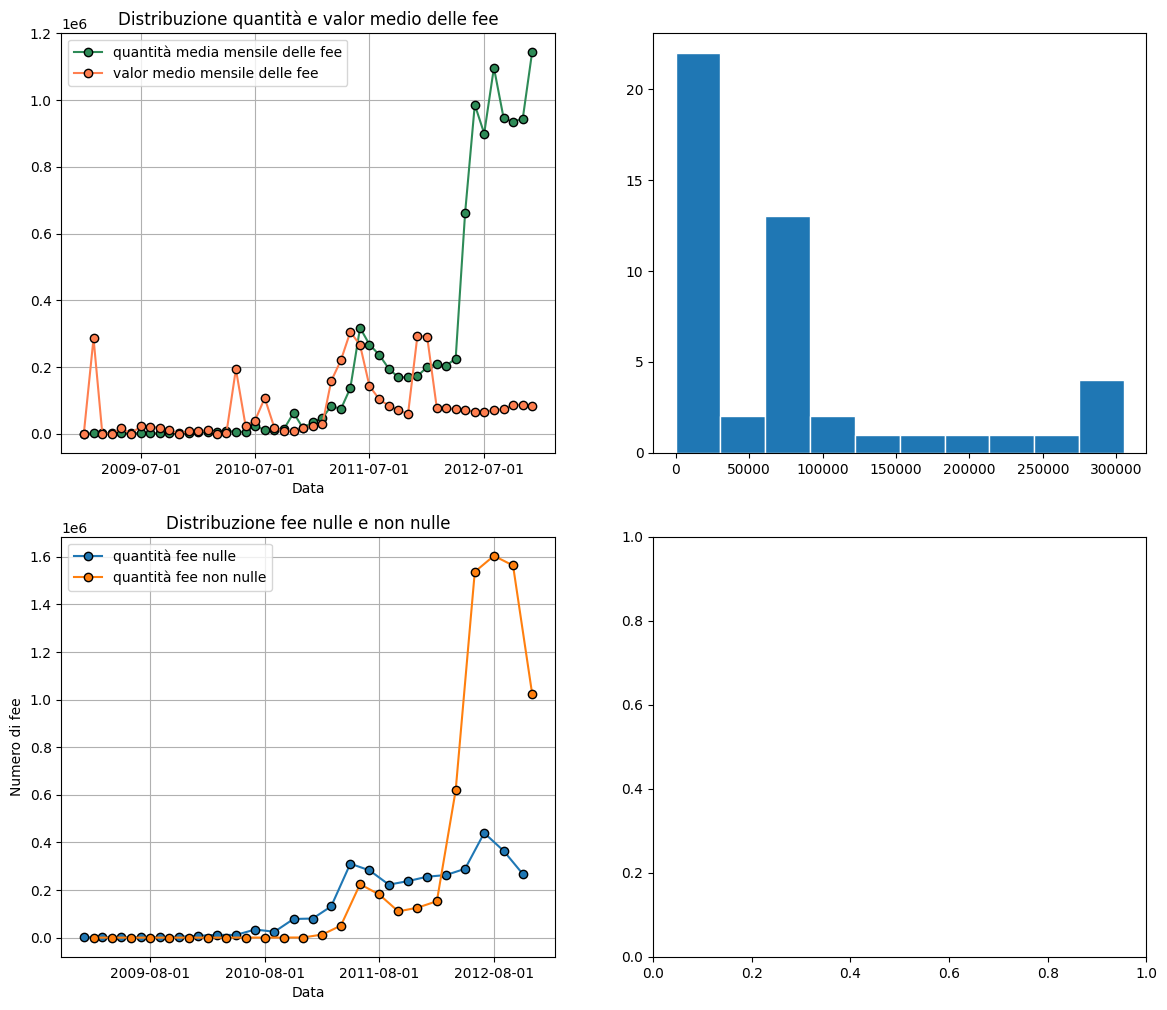

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0][0].plot(
    fee_count.index,
    fee_count,
    "o-",
    mec="k",
    label="quantità media mensile delle fee",
    c="seagreen",
)

axes[0][0].plot(
    fee_value.index,
    fee_value,
    "o-",
    mec="k",
    label="valor medio mensile delle fee",
    c="coral",
)
axes[0][0].set_title("Distribuzione quantità e valor medio delle fee")
axes[0][0].set_xlabel("Data")
axes[0][0].set_xticks([ts for ts in zero_fee_count.index if ts.month % 7 == 0])
axes[0][0].grid()
axes[0][0].legend()

axes[0][1].hist(fee_value, ec="w")

axes[1][0].plot(
    zero_fee_count.index,
    zero_fee_count,
    "o-",
    mec="k",
    label="quantità fee nulle",
    # c="mediumslateblue",
)


axes[1][0].plot(
    non_zero_fee_count.index,
    non_zero_fee_count,
    "o-",
    mec="k",
    label="quantità fee non nulle",
    # c="blueviolet",
)

axes[1][0].set_title("Distribuzione fee nulle e non nulle")
axes[1][0].set_xlabel("Data")
axes[1][0].set_ylabel("Numero di fee")
axes[1][0].set_xticks([ts for ts in non_zero_fee_count.index if ts.month % 8 == 0])
axes[1][0].grid()
axes[1][0].legend()

plt.show()

## Clusterizzazione degli indirizzi

In questa fase vogliamo implementare l'**euristica multi-input** per la clusterizzazione degli
indirizzi.

L'obbiettivo è quello di riunire in cluster, gli indirizzi appartenenti ad uno stesso utente.

### Grafo degli indirizzi

Per costruire il grafo degli indirizzi dobbiamo:

1. Individuare le transazioni usate come input di ogni transazione.
2. Individuare gli indirizzi di tali transazioni.
3. Per ogni transazione, collegare il primo indirizzo della prima transazione di input con tutti
   gli altri indirizzi delle altre transazioni di input.

Utilizziamo il DataFrame `spent_df` creato in precedenza per il calcolo dell'UTXO poiché mette
sulla stessa riga due transazioni:

- Sulla colonna `tx` troviamo transazioni che riferiscono altre transazioni come loro input.
- Sulla colonna `in_tx` troviamo transazioni riferite come input e di cui conosciamo l'address di
  destinazione.

L'euristica di **clustering** prevede inoltre che si considerino transazioni con più di un input,
sarà necessario filtrare il dataset di conseguenza.


In [17]:
mapping_df = pd.read_csv(
    "mappings.csv",
    names=["hash", "address"],
    dtype={"hash": str, "address": np.uint32},
    nrows=n,
)

more_than_1 = spent_df.groupby("tx")["in_tx"].count().reset_index()
more_than_1 = more_than_1[more_than_1["in_tx"] > 1].rename(
    columns={"in_tx": "in_count"}
)
more_than_1 = more_than_1.merge(spent_df, how="inner", on="tx").drop(
    columns=["in_count"]
)

more_than_1 = more_than_1.merge(mapping_df, how="inner", on="address")

del spent_df
del mapping_df

Ora possiamo popolare il grafo andando a prendere per ogni transazione l'indirizzo del primo input
per collegarlo agli indirizzi degli altri input della stessa transazione.

Per evitare archi in loop sullo stesso nodo controlliamo che i due nodi siano differenti prima di
aggiungere l'arco.

Non è necessario controllare che un arco venga aggiunto più volte poiché, se ci provassimo, il
risultato sarebbe in quanto il controllo viene già fatto internamente da `NetworkX`.

Non ho aggiunto tutti gli address presenti nel dataset di mapping come nodi del grafo:

- Per risparmiare memoria.
- Molti sarebbero rimasti nodi singoli se non riferiti.

Calcoliamo infine le componenti connesse ottenendo i cluster e ordiniamoli per dimensione.


In [18]:
addr_graph = nx.Graph()
addresses = more_than_1.groupby("tx")["hash"].apply(list)
for a in addresses:
    for i in range(1, len(a)):
        if a[0] != a[i]:
            addr_graph.add_edge(a[0], a[i])

clusters = sorted(nx.connected_components(addr_graph), key=len, reverse=True)

del addr_graph
del more_than_1

### Analisi cluster

Procediamo ora con qualche analisi sui cluster ottenuti come

- Dimensione media, minima e massima dei cluster.
- Distribuzione della dimensione dei cluster.

Uno degli obbiettivi è quello di mettere in evidenza la distribuzione _power low_ della dimensione
dei cluster.


In [19]:
cluster_sizes = [len(cluster) for cluster in clusters]

print(f"Numero di cluster trovati: {len(clusters)}")
print(f"Dimensione media: {np.mean(cluster_sizes):.4f}")
print(f"Dimensione minima: {cluster_sizes[-1]}")
print(f"Dimensione massima: {cluster_sizes[0]}")
print(f"Dimensione dei 10 cluster più grandi: {cluster_sizes[:10]}")

Numero di cluster trovati: 498020
Dimensione media: 8.8475
Dimensione minima: 2
Dimensione massima: 259773
Dimensione dei 10 cluster più grandi: [259773, 121464, 99645, 76923, 40969, 30916, 26615, 20136, 19894, 16977]


#### Plot

Come plot ho optato per:

- Un istogramma delle frequenze per ciascuna dimensione
- Uno scatter plot in grado di evidenziare la distribuzione _power low_ che governa tali dimensioni.


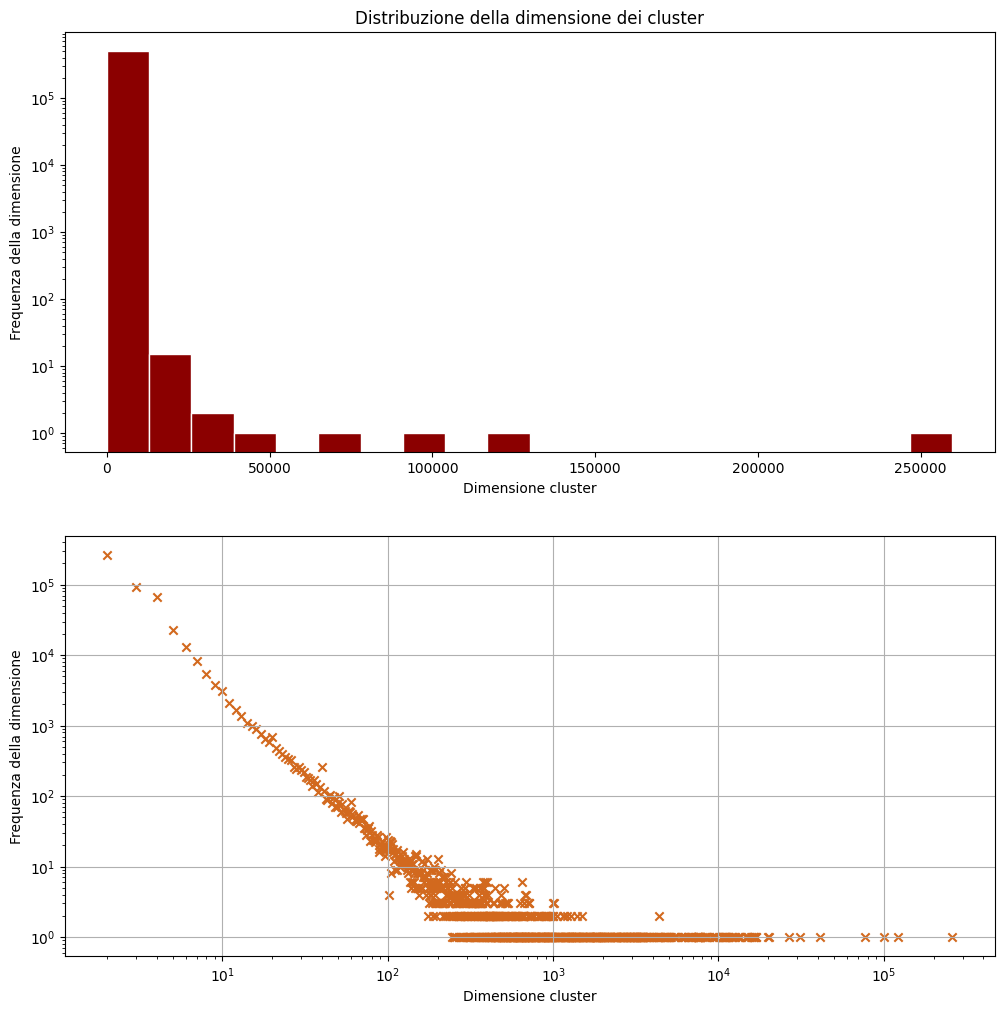

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.hist(cluster_sizes, bins=20, ec="w", color="darkred")
ax1.set_title("Distribuzione della dimensione dei cluster")
ax1.set_xlabel("Dimensione cluster")
ax1.set_ylabel("Frequenza della dimensione")
ax1.set_yscale("log")

cluster_sizes_count = {cs: 0 for cs in cluster_sizes}
for cs in cluster_sizes:
    cluster_sizes_count[cs] += 1

data = list(zip(*[(k, cluster_sizes_count[k]) for k in cluster_sizes_count.keys()]))

ax2.scatter(list(data[0]), list(data[1]), marker="x", c="chocolate")
ax2.set_xlabel("Dimensione cluster")
ax2.set_ylabel("Frequenza della dimensione")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid()

plt.show()

## Deanonimizzazione

Passiamo alla parte di deanonimizzazione degli indirizzi considerando solo i 10 cluster più grandi.

Per entrambi i siti ho utilizzato gli strumenti della libreria `BeautifulSoup` in quanto le pagine
fornivano le informazioni rilevanti nel loro codice `html`.

### WalletExplorer

Ho iniziato dal sito [WalletExplorer](https://www.walletexplorer.com/) che si presenta con una
`form` in cui è possibile inserire l'hash dell'indirizzo che cerchiamo.

![wallet_explorer1_img](images/wallet_explorer1.png)

Il `tag` che cerchiamo è un tag di input con il campo `name` equivalente a `q`. Possiamo dunque
effettuare una richiesta `GET` in cui specifichiamo il parametro `params` tramite un dizionario in
modo da ottenere una pagina simile a questa

![wallet_explorer2_img](images/wallet_explorer2.png)

L'informazione che cerchiamo si trova nel primo tag `h2` che troviamo nella pagina.

![wallet_explorer4](images/wallet_explorer4.png)

Una volta agganciato il tag con `BeautifulSoup` possiamo direttamente ricavare il testo contenuto
tramite la funzione `get_text()`.

Se la stringa che ricaviamo è un numero racchiuso tramite parentesi quadre significa che non siamo
riusciti a deanonimizzare l'indirizzo.

Se invece troviamo una parola siamo riusciti a deanonimizzare l'indirizzo e possiamo passare al
cluster successivo.

#### AntiScraping

Nel caso in cui si effetuino troppe richieste in poco tempo alla pagina questa ci blocca ritornando
un codice di errore `429`.

Per evitare di essere bloccato ho limitato a 10 il numero di richieste per ogni cluster e ho
aggiunto un ritardo di 3 secondi tra una richiesta e l'altra.


In [21]:
base_url = "https://www.walletexplorer.com/"
session = requests.Session()
session.headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
    + " (KHTML, like Gecko) Chrome/61.0.3163.100Safari/537.36"
}


def scrape_wallet_explorer(address: str) -> None | str:
    r = session.get(base_url, params={"q": address})
    if r.status_code == 200:
        soup = bs4.BeautifulSoup(r.text, "html.parser")
        wallet_tag = soup.find("h2")
        if isinstance(wallet_tag, bs4.Tag):
            text = wallet_tag.get_text()
            wallet_name = text.split(" ")[1]
            if wallet_name.startswith("["):
                return None
            else:
                return wallet_name
    else:
        return f"Errore {r.status_code}: {r.reason}"


too_many_requests = False
for cluster_ID, cluster in enumerate(clusters[:10], start=1):
    if too_many_requests == True:
        break
    for addr_ID, addr in enumerate(cluster):
        if addr_ID < 10:
            time.sleep(3)
            wallet_name = scrape_wallet_explorer(addr)
            if wallet_name != None:
                if wallet_name.startswith("Errore"):
                    too_many_requests = True
                print(f"Cluster {cluster_ID}: {wallet_name}")
                break
        else:
            print(f"Cluster {cluster_ID}: Anonimo")
            break

session.close()

Cluster 1: CoinJoinMess
Cluster 2: SilkRoadMarketplace
Cluster 3: Anonimo
Cluster 4: Instawallet.org
Cluster 5: Anonimo
Cluster 6: BTC-e.com-old
Cluster 7: BtcDice.com
Cluster 8: Anonimo
Cluster 9: Anonimo
Cluster 10: Anonimo


### BitInfoCharts

Per la seconda fase di scraping esploriamo il sito [BitInfoCharts](https://bitinfocharts.com/) la
cui URL può essere estesa con `bitcoin/address/<address hash>` per ottenere una pagina di questo
tipo

![bit_info_charts1](images/bit_info_charts2.png)

Come vediamo all'interno della pagina è presente un tag di tipo `small` in cui troviamo sempre del
il nome di un _wallet_.

Se il nome del wallet non è una cifra siamo riusciti a deanonimizzare l'indirizzo, in caso
contrario dobbiamo compiere altri tentativi.

#### Antiscraping

Questo sito permette maggiore libertà in fase di scraping, infatti sono riuscito ad inviare anche
centinaia di richieste per tentare di deanonimizzare gli indirizzi di uno stesso cluster. Il tutto
senza aggiungere ritardo tra l'una e l'altra richiesta.

In ogni caso anche in questo caso sarebbe preferibile limitare il numero di richieste e introdurre
un minimo di ritardo tra di esse per poter effettuare più prove.


In [22]:
base_url = "https://bitinfocharts.com/bitcoin/address/"
session = requests.Session()
session.headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
    + " (KHTML, like Gecko) Chrome/61.0.3163.100Safari/537.36"
}


def scrape_bit_info_charts(address: str) -> None | str:
    r = session.get(base_url + address)
    if r.status_code == 200:
        soup = bs4.BeautifulSoup(r.text, "html.parser")
        small_tags = soup.find_all("small")
        for tag in small_tags:
            if isinstance(tag, bs4.Tag):
                text = tag.get_text()
                if text.startswith("wallet:"):
                    return text.split(" ")[1]

        return None
    else:
        return f"Errore {r.status_code}: {r.reason}"


http_error = False
for cluster_ID, cluster in enumerate(clusters[:10], start=1):
    if http_error == True:
        break
    for addr_ID, addr in enumerate(cluster):
        if addr_ID < 10:
            time.sleep(2)
            wallet_name = scrape_bit_info_charts(addr)
            if wallet_name != None and not wallet_name.isdigit():
                if wallet_name.startswith("Errore"):
                    http_error = True
                    print(wallet_name)
                    break
                print(f"Cluster {cluster_ID}: {wallet_name}")
                break
        else:
            print(f"Cluster {cluster_ID}: Anonimo")
            break

session.close()

Cluster 1: F2Pool
Cluster 2: SilkRoadMarketplace
Cluster 3: Anonimo
Cluster 4: Instawallet.org
Cluster 5: Anonimo
Cluster 6: Eligius
Cluster 7: Anonimo
Cluster 8: Anonimo
Cluster 9: Anonimo
Cluster 10: Anonimo


### Conclusioni

Tramite il sito [WalletExplorer](https://www.walletexplorer.com/) sono riuscito a deanonimizzare
5 servizi.

Tramite il sito [BitInfoCharts](https://bitinfocharts.com/) sono invece riuscito a deanonimizzare
4 servizi.
